In [1]:
import pandas as pd
import geopandas
import eust
import matplotlib as mpl
import matplotlib.pyplot as plt
import hierarchy
import nuts
import settings
import plots

## Read NUTS nomenclature data

In [2]:
NUTS_TABLE = nuts.get_nuts_candidates()
EU28_COUNTRIES = NUTS_TABLE.country_code.unique()
NUTS_TABLE

,country_code,nuts_level,label,parent_geo,country
geo,,,,,
AT,AT,0,ÖSTERREICH,NaN,Austria
AT1,AT,1,OSTÖSTERREICH,AT,Austria
AT11,AT,2,Burgenland (AT),AT1,Austria
AT12,AT,2,Niederösterreich,AT1,Austria
AT13,AT,2,Wien,AT1,Austria
...,...,...,...,...,...
UKM3,UK,2,South Western Scotland,UKM,United Kingdom
UKM5,UK,2,North Eastern Scotland,UKM,United Kingdom
UKM6,UK,2,Highlands and Islands,UKM,United Kingdom


# Manure excretion calculation

## Load livestock populations from FSS (table `ef_olsaareg`)

In [3]:
EXCLUDED_FLAGS = ['u']

In [4]:
EF_OLSAAREG_DATA_VERSION = '2019-05-08 23:00:00'

In [5]:
livestock_pop = (
    eust.read_table_data('ef_olsaareg', version=EF_OLSAAREG_DATA_VERSION)
    .loc[lambda d: ~d.flag.isin(EXCLUDED_FLAGS)]
    .value
    .xs('TOTAL', level='agrarea')
    .xs(settings.DATA_YEAR, level='time')
    .loc[lambda s: s.index.get_level_values('indic_ef').str.endswith('HEADS')]
    .dropna()
    .reorder_levels(['geo', 'indic_ef'])
    .sort_index()
)
livestock_pop

geo   indic_ef        
AT    C_1_HEADS            79300.0
      C_2_1_HEADS         619800.0
      C_2_2_HEADS         164910.0
      C_2_3_HEADS         265400.0
      C_2_4_HEADS          15150.0
                            ...   
UKN0  C_4_HEADS           453800.0
      C_5_1_1000_HEADS     12300.0
      C_5_2_1000_HEADS      6430.0
      C_5_3_1000_HEADS       370.0
      C_6_HEADS                0.0
Name: value, Length: 6500, dtype: float64

In [6]:
eust.read_table_metadata('ef_olsaareg')['dimensions'].loc['indic_ef']

,label
code,
C_1_HEADS,head: Equidae
C_1_HOLD,hold: Equidae
C_2_1_HEADS,head: Bovine <1 year old - total
C_2_1_HOLD,hold: Bovine <1 year old - total
C_2_2_HEADS,head: Bovine 1-<2 years - males
C_2_2_HOLD,hold: Bovine 1-<2 years - males
C_2_3_HEADS,head: Bovine 1-<2 years - females
C_2_3_HOLD,hold: Bovine 1-<2 years - females
C_2_4_HEADS,head: Bovine 2 years and older - males


## Load OECD excretion factors

In [7]:
def first_word(s):
    return s.split(' ')[0]

def transform_index(d, func):
    return d.set_index(d.index.map(func))
    
oecd_excr_data = (
    pd.read_excel(
        settings.LIVEDATE_EXCRETION_PATH,
        sheet_name='P excretion Eurostat OECD',
        skiprows=[0, 3],
        header=[0, 1],
        index_col=0,
    )
    .rename_axis('animal')
    .rename_axis(['geo_nutrient', 'time'], axis=1)
    .stack(['geo_nutrient', 'time'])
    .sort_index()
    .groupby(['animal', 'geo_nutrient'])
    .last()
    .unstack('geo_nutrient')
    .pipe(transform_index, first_word) # extract animal code
    .T
    .pipe(transform_index, first_word) # extract country code
    .reindex(EU28_COUNTRIES)
    .rename_axis('country_code')
    .dropna(how='all', axis=1) # drop livestock categories without data
)
oecd_excr_data

animal,A111911_OECD,A111912_OECD,A111921_OECD,A111922_OECD,A112111_OECD,A112112_OECD,A112211_OECD,A112212_OECD,A112221_OECD,A112223_OECD,...,PP4000,PP4100,PP4200,PP4210,PP4211,PP4220,PP4221,PS0000,PS1000,PS2000
country_code,,,,,,,,,,,,,,,,,,,,,
AT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.118000,NaN,...,NaN,5.362800,4.621600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.947197,12.928373,...,NaN,NaN,NaN,5.088235,NaN,4.833541,NaN,1.540656,NaN,NaN
BG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.300000,5.700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.379547,6.472655,NaN,NaN,NaN,NaN,1.675677,NaN,NaN
CZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.200000,NaN,...,NaN,4.900000,4.900000,NaN,NaN,NaN,NaN,1.900000,NaN,NaN
DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.560000,NaN,...,NaN,3.520000,6.160000,6.160000,6.16,6.160000,6.16,NaN,NaN,NaN
DK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.605479,NaN,...,NaN,4.561389,5.096856,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.400000,NaN,6.400000,NaN,NaN,NaN,NaN,1.500000,NaN,NaN
EL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
oecd_excr_data.sort_index().loc[:, 'FSS':]

animal,FSS_J1,FSS_J14,FSS_J15,FSS_J16,FSS_J16A,FSS_J16B,FSS_J16C,FSS_J16CD,FSS_J16DII,FSS_J17,...,PP4000,PP4100,PP4200,PP4210,PP4211,PP4220,PP4221,PS0000,PS1000,PS2000
country_code,,,,,,,,,,,,,,,,,,,,,
AT,NaN,0.074120,0.196200,NaN,0.261600,0.109000,NaN,0.109000,NaN,NaN,...,NaN,5.362800,4.621600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BE,9.979568,0.081653,0.148873,0.172587,0.442926,NaN,NaN,NaN,0.082958,2.107067,...,NaN,NaN,NaN,5.088235,NaN,4.833541,NaN,1.540656,NaN,NaN
BG,5.987155,0.079511,0.132129,0.506639,NaN,NaN,NaN,NaN,NaN,2.700000,...,NaN,5.300000,5.700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CY,8.615121,0.072292,0.163172,0.133906,NaN,NaN,NaN,NaN,NaN,1.477668,...,NaN,5.379547,6.472655,NaN,NaN,NaN,NaN,1.675677,NaN,NaN
CZ,NaN,0.200000,0.300000,NaN,0.600000,0.300000,NaN,0.300000,NaN,NaN,...,NaN,4.900000,4.900000,NaN,NaN,NaN,NaN,1.900000,NaN,NaN
DE,NaN,0.070400,0.158400,NaN,0.352000,0.074800,0.0880,NaN,NaN,NaN,...,NaN,3.520000,6.160000,6.160000,6.16,6.160000,6.16,NaN,NaN,NaN
DK,NaN,0.160995,0.258567,NaN,0.602859,0.351958,NaN,0.425138,NaN,NaN,...,NaN,4.561389,5.096856,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EE,NaN,0.058500,0.195000,0.195000,NaN,NaN,NaN,NaN,NaN,NaN,...,6.400000,NaN,6.400000,NaN,NaN,NaN,NaN,1.500000,NaN,NaN
EL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Translate OECD livestock codes to FSS nomenclature

In [9]:
OECD_EUROSTAT_LIVESTOCK_TRANSLATION = {
    'C_1_HEADS': 'FSS_J1',
    'C_2_1_HEADS': 'PC1000',
    'C_2_2_HEADS': 'PC2100',
    'C_2_4_HEADS': 'PC3100',
    'C_2_3_HEADS': 'PC2200',
    'C_2_5_HEADS': 'PC3211',
    'C_2_6_HEADS': 'PC3221',
    'C_2_99_HEADS': 'PC3222',
    'C_3_1_HEADS': 'PS0000',
    'C_3_2_HEADS': 'PG0000',
    'C_4_1_HEADS': 'PP1000',
    'C_4_2_HEADS': 'PP4200',
    'C_4_99_HEADS': 'PP3000',
    'C_5_1_1000_HEADS': '1000 * FSS_J14',
    'C_5_2_1000_HEADS': '1000 * FSS_J15',
    'C_5_3_1000_HEADS': '1000 * FSS_J16', # Other poultry
    'C_6_HEADS': 'FSS_J17',
}

fss_excretion_factors = (
    pd.DataFrame({
        key: oecd_excr_data.eval(formula)
        for key, formula in OECD_EUROSTAT_LIVESTOCK_TRANSLATION.items()
    })
    .rename_axis('indic_ef', axis=1)
    .reindex(EU28_COUNTRIES)
    .pipe(lambda d: d.fillna(d.median()))
    .stack()
    .rename('excretion_factor')
)
fss_excretion_factors

country_code  indic_ef        
AT            C_1_HEADS             9.214665
              C_2_1_HEADS           3.300000
              C_2_2_HEADS           8.097963
              C_2_4_HEADS          10.812800
              C_2_3_HEADS           7.617393
                                     ...    
UK            C_4_99_HEADS          2.584178
              C_5_1_1000_HEADS    123.900000
              C_5_2_1000_HEADS    441.410484
              C_5_3_1000_HEADS    172.586689
              C_6_HEADS             2.119876
Name: excretion_factor, Length: 476, dtype: float64

In [27]:
fss_excretion_factors.unstack().round(1)

indic_ef,C_1_HEADS,C_2_1_HEADS,C_2_2_HEADS,C_2_4_HEADS,C_2_3_HEADS,C_2_5_HEADS,C_2_6_HEADS,C_2_99_HEADS,C_3_1_HEADS,C_3_2_HEADS,C_4_1_HEADS,C_4_2_HEADS,C_4_99_HEADS,C_5_1_1000_HEADS,C_5_2_1000_HEADS,C_5_3_1000_HEADS,C_6_HEADS
country_code,,,,,,,,,,,,,,,,,
AT,9.2,3.3,8.1,10.8,7.6,11.1,16.3,12.3,1.6,2.0,0.9,4.6,1.9,74.1,196.2,172.6,2.1
BE,10.0,3.3,8.2,12.9,7.7,12.9,15.3,13.7,1.5,1.4,0.6,6.0,2.6,81.7,148.9,172.6,2.1
BG,6.0,5.6,8.2,10.1,7.7,9.0,15.1,12.0,1.6,1.6,0.8,5.7,2.4,79.5,132.1,506.6,2.7
CY,8.6,3.3,6.1,8.1,7.7,7.7,16.2,13.8,1.7,1.8,0.9,6.5,2.6,72.3,163.2,133.9,1.5
CZ,9.2,3.3,8.3,11.5,6.8,8.2,15.2,11.5,1.9,1.9,0.8,4.9,3.5,200.0,300.0,172.6,2.1
DE,9.2,5.3,8.8,10.6,8.8,10.6,17.2,13.2,1.6,3.5,0.9,6.2,2.6,70.4,158.4,172.6,2.1
DK,9.2,3.3,7.9,8.3,7.6,9.1,19.0,11.1,1.6,1.6,0.4,5.1,3.2,161.0,258.6,172.6,2.1
EE,9.2,2.0,8.0,10.1,6.0,9.0,14.8,14.8,1.5,1.5,0.2,6.4,1.0,58.5,195.0,195.0,2.1
EL,9.2,3.3,8.1,10.1,7.6,9.0,16.0,13.2,1.6,1.6,0.8,6.0,2.6,79.5,170.0,172.6,2.1


In [10]:
included_livestock = (
    livestock_pop
    .reindex(fss_excretion_factors.index.unique('indic_ef'), level='indic_ef')
    .dropna()
    .rename('heads')
)
included_livestock

geo   indic_ef        
AT    C_1_HEADS            79300.0
      C_2_1_HEADS         619800.0
      C_2_2_HEADS         164910.0
      C_2_4_HEADS          15150.0
      C_2_3_HEADS         265400.0
                            ...   
UKN0  C_4_99_HEADS        264900.0
      C_5_1_1000_HEADS     12300.0
      C_5_2_1000_HEADS      6430.0
      C_5_3_1000_HEADS       370.0
      C_6_HEADS                0.0
Name: heads, Length: 4805, dtype: float64

## Load total LSU per region from FSS

In [11]:
total_LSU = (
    eust.read_table_data('ef_olsaareg', version=EF_OLSAAREG_DATA_VERSION)
    .value
    .xs('C_LIVESTOCK_LSU', level='indic_ef')
    .xs('TOTAL', level='agrarea')
    .xs(settings.DATA_YEAR, level='time')
    .reindex(EU28_COUNTRIES)
    .rename('total')
    .rename_axis('country_code')
)
total_LSU

country_code
AT     2439090.0
BE     3584440.0
BG     1024910.0
CY      174520.0
CZ     1728360.0
DE    18406910.0
DK     4133390.0
EE      310110.0
EL     2142980.0
ES    14501690.0
FI     1145730.0
FR    21871300.0
HR      864020.0
HU     2259080.0
IE     5929360.0
IT     9374270.0
LT      838750.0
LU      165400.0
LV      485990.0
MT       34930.0
NL     6602050.0
PL     9164570.0
PT     2035510.0
RO     4975310.0
SE     1711740.0
SI      487960.0
SK      644820.0
UK    13282320.0
Name: total, dtype: float64

## Calculate sum of observed LSU in each region

In [12]:
eust.read_table_metadata('ef_olsaareg')['dimensions'].loc['indic_ef']

,label
code,
C_1_HEADS,head: Equidae
C_1_HOLD,hold: Equidae
C_2_1_HEADS,head: Bovine <1 year old - total
C_2_1_HOLD,hold: Bovine <1 year old - total
C_2_2_HEADS,head: Bovine 1-<2 years - males
C_2_2_HOLD,hold: Bovine 1-<2 years - males
C_2_3_HEADS,head: Bovine 1-<2 years - females
C_2_3_HOLD,hold: Bovine 1-<2 years - females
C_2_4_HEADS,head: Bovine 2 years and older - males


In [13]:
LSU_FACTORS = (
    pd.Series({
        'C_1_HEADS': 0.8,
        'C_2_1_HEADS': 0.4,
        'C_2_2_HEADS': 0.7,
        'C_2_4_HEADS': 1,
        'C_2_3_HEADS': 0.7,
        'C_2_5_HEADS': 0.8,
        'C_2_6_HEADS': 1,
        'C_2_99_HEADS': 0.8,
        'C_3_1_HEADS': 0.1,
        'C_3_2_HEADS': 0.1,
        'C_4_1_HEADS': 0.027,
        'C_4_2_HEADS': 0.5,
        'C_4_99_HEADS': 0.3,
        'C_5_1_1000_HEADS': 0.007 * 1000,
        'C_5_2_1000_HEADS': 0.014 * 1000,
        'C_5_3_1000_HEADS': 0.03 * 1000,
        'C_6_HEADS': 0.02,
    })
    .rename_axis('indic_ef')
)

included_LSU = (
    included_livestock
    .mul(LSU_FACTORS)
    .groupby('geo')
    .sum()
)
included_LSU.head()

geo
AT      2438942.84
AT11      38140.42
AT12     577476.74
AT13        184.00
AT21     193866.52
dtype: float64

## Compare calculated sum of LSU to reported total

Note that calculated sum of LSU is almost exactly equal to reported total.

This holds clearly on country level but also to good accuracy in most NUTS2 regions.

This means we do not have to make any estimates of excretion in non-observed livestock classes.

In [14]:
(
    included_LSU
    .rename('sum')
    .to_frame()
    .join(NUTS_TABLE[['nuts_level', 'country_code']], how='inner')
    .groupby(['country_code', 'nuts_level'])
    .sum()['sum']
    .div(total_LSU)
    .unstack()
    .round(3)
)

nuts_level,0,1,2
country_code,,,
AT,1.000,NaN,1.000
BE,1.000,NaN,1.000
BG,1.000,NaN,1.000
CY,0.999,NaN,0.999
CZ,1.000,NaN,0.996
DE,1.000,1.0,NaN
DK,1.000,NaN,1.000
EE,1.000,NaN,1.000
EL,1.000,NaN,1.000


In [28]:
excretion = (
    included_livestock
    .to_frame()
    .join(NUTS_TABLE.country_code)
    .join(fss_excretion_factors, on=['country_code', 'indic_ef'])
    .eval('excretion_factor * heads')
    .groupby('geo')
    .sum()
    .mul(1e-6) # to Gg P
    .rename('excretion')
)
excretion

geo
AT      27.834650
AT11     0.395425
AT12     6.347312
AT13     0.002201
AT21     2.369130
          ...    
UKM2    10.211552
UKM3    11.429717
UKM5     4.001366
UKM6     6.979625
UKN0    23.973491
Name: excretion, Length: 286, dtype: float64

# Plot and inspect excretion / ha UAA

In [29]:
uaa = (
    eust.read_table_data('ef_lus_allcrops')
    .value
    .xs('UAA', level='crops')
    .xs('HA', level='unit')
    .xs('TOTAL', level='agrarea')
    .xs(settings.DATA_YEAR, level='time')
    .div(1e6) # to Mha
    .pipe(nuts.fill_nuts)
)
uaa

geo
AT      2.72689
AT1     1.09884
AT11    0.18197
AT12    0.90885
AT13    0.00802
         ...   
UKM3    0.79834
UKM5    0.47877
UKM6    2.76356
UKN     1.04614
UKN0    1.04614
Name: value, Length: 428, dtype: float64

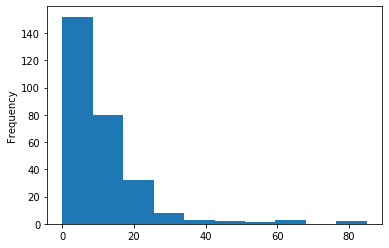

In [30]:
excretion.div(uaa).plot.hist()

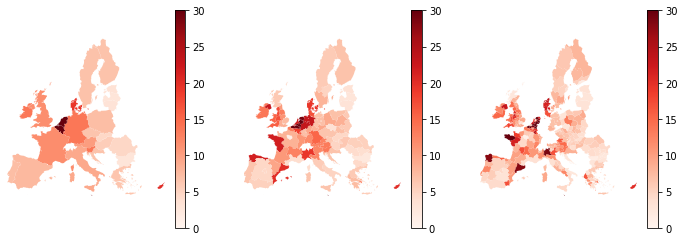

In [31]:
nuts_levels = [0, 1, 2]
fig, axs = plt.subplots(ncols=len(nuts_levels), figsize=(4 * len(nuts_levels), 4))

nuts_geo = geopandas.read_file(settings.NUTS_GIS_PATH).set_index('NUTS_ID')
filled_excretion = excretion.pipe(nuts.fill_nuts).div(uaa).dropna().rename('excretion')
for level, ax in zip(nuts_levels, axs):
    (
        nuts_geo
        .join(filled_excretion, how='inner')
        .pipe(nuts.filter_nuts_level, level)
        .plot('excretion', legend=True, cmap=mpl.cm.Reds,  vmin=0, vmax=30, ax=ax)
    )
    plots.adj_geoplot(ax)

In [32]:
excretion.to_csv(settings.EXCRETION_PATH, header=True)